In [1]:
import pandas as pd
import numpy as np
import igraph as ig
import os
os.chdir('..')
from PairingVDJdb_MI import _define_individuals
from PairingVDJdb_GA import get_mode, check_correct_pairs_ID
import functions.myfunctions as mf

In [2]:
ff0 = 'data/output/pairing_GA/all_eps/'
ff01 = 'data/output/pairing_GA/big_eps_700/'
ff1 = 'data/output/pairwise_distances/cdr3/'

save_folder1 = 'figures'

In [3]:
vdj = pd.read_csv('data/vdj_cleaned_subset_for_MI.csv', index_col=0).drop('Unnamed: 0', axis=1)
vdj = vdj.replace('https://www.10xgenomics.com/resources/application-notes/a-new-way-of-exploring-immunity-linking-highly-multiplexed-antigen-recognition-to-immune-repertoire-and-phenotype/#', '10xGenomics')
vdj = vdj.replace('https://github.com/antigenomics/vdjdb-db/issues/*', 'GitHubIssue', regex=True)
vdj = vdj.loc[vdj['Epitope'] != 'KLGGALQAK'] # because too big - takes forever
epitopes = vdj['Epitope'].unique().tolist()
# epcounts = vdj['Epitope'].value_counts()
# epitopes = epcounts.loc[epcounts<1000].index.values
# vdj = vdj.loc[vdj['Epitope'].isin(epitopes)]

In [4]:
all_res = pd.DataFrame()

for ff in os.listdir(ff0):
    if 'distance_type-lev_kNN-20' in ff:
        print(ff)
        ep = ff.split('epitope-')[1].split('_')[0]
        epdf = _define_individuals(vdj, ep, 'no')
        # epdf = mf.prepare_data(epdf, col1='cdr3a_IMGTgaps', col2 ='cdr3b_IMGTgaps')

        GA = pd.read_csv(ff0 + ff, index_col=0)
        correct_pairs = (GA['alpha'].str.replace(', ','').str.replace('-','') + '::' \
                            + GA['correct_beta'].str.replace(', ','').str.replace('-','') + '::' \
                                + GA['subject-PMID']).tolist()
        IDs = GA['subject-PMID'].tolist()
        GA_nomode = GA.copy()
        GA_nomode = GA_nomode.drop('correct', axis=1)
        GA_many_modes = pd.DataFrame()
    
        for w in range(100):
            GA1 = get_mode(GA_nomode)
            GA1 = check_correct_pairs_ID(GA1, correct_pairs, IDs)
            GA1['mode_iter'] = w
            GA_many_modes = pd.concat([GA_many_modes, GA1[['alpha','mode_iter','correct']]])
        GA_many_modes = GA_many_modes.groupby(['mode_iter','correct']).count().reset_index()
        c1 = GA_many_modes.loc[GA_many_modes['correct'] == True]['alpha'].mean()

        c = GA.loc[GA['correct'] == True].shape[0]
        print(c, c1)
        assert abs(c-c1) < 2
        N = GA.shape[0]
        all_res.loc[ep,'correct'] = c1
        all_res.loc[ep,'N'] = N
        all_res.loc[ep,'prop_correct'] = c1/N
        all_res.loc[ep,'largest_id'] = epdf['subject-PMID'].value_counts().max()

        A_sim = pd.read_csv(ff1 + 'dijA_lev_'+ep+'.csv', index_col=0)
        B_sim = pd.read_csv(ff1 + 'dijB_lev_'+ep+'.csv', index_col=0)

        dij_A = np.array(A_sim <= 2, dtype=int)
        dij_B = np.array(B_sim <= 2, dtype=int)
        np.fill_diagonal(dij_B, 0)
        np.fill_diagonal(dij_A, 0)

        assert dij_A.shape[0] == dij_A.shape[1] == N
        assert dij_B.shape[0] == dij_B.shape[1] == N

        gA = ig.Graph.Adjacency(dij_A, mode='undirected')
        gB = ig.Graph.Adjacency(dij_B, mode='undirected')

        avgA = np.mean(gA.degree())
        avgB = np.mean(gB.degree())
        all_res.loc[ep,'avg_degree_A'] = avgA
        all_res.loc[ep,'avg_degree_B'] = avgB

        clusters = gA.community_multilevel()
        clus_size_A = pd.Series(clusters.membership).value_counts()
        all_res.loc[ep,'large_clus_A'] = clus_size_A[clus_size_A > 2].shape[0]
        all_res.loc[ep,'prop_singlets_A'] = clus_size_A[clus_size_A == 1].shape[0]/N

        clusters = gB.community_multilevel()
        clus_size_B = pd.Series(clusters.membership).value_counts()
        all_res.loc[ep,'large_clus_B'] = clus_size_B[clus_size_B > 2].shape[0]
        all_res.loc[ep,'prop_singlets_B'] = clus_size_B[clus_size_B == 1].shape[0]/N

GA-epitope-ASNENMETM_ind-no_vgene-no_distance_type-lev_kNN-20_n_repeats-100.csv.gz
Using individuals as provided
85 85.52
GA-epitope-ATDALMTGF_ind-no_vgene-no_distance_type-lev_kNN-20_n_repeats-100.csv.gz
Using individuals as provided
3 3.0
GA-epitope-CINGVCWTV_ind-no_vgene-no_distance_type-lev_kNN-20_n_repeats-100.csv.gz
Using individuals as provided
8 8.0
GA-epitope-ELAGIGILTV_ind-no_vgene-no_distance_type-lev_kNN-20_n_repeats-100.csv.gz
Using individuals as provided
17 16.09
GA-epitope-GLCTLVAML_ind-no_vgene-no_distance_type-lev_kNN-20_n_repeats-100.csv.gz
Using individuals as provided
87 87.45
GA-epitope-HGIRNASFI_ind-no_vgene-no_distance_type-lev_kNN-20_n_repeats-100.csv.gz
Using individuals as provided
35 35.0
GA-epitope-IVTDFSVIK_ind-no_vgene-no_distance_type-lev_kNN-20_n_repeats-100.csv.gz
Using individuals as provided
199 200.79
GA-epitope-KSKRTPMGF_ind-no_vgene-no_distance_type-lev_kNN-20_n_repeats-100.csv.gz
Using individuals as provided
7 7.0
GA-epitope-LLWNGPMAV_ind-no_vge

In [5]:
for ff010 in os.listdir(ff01):
    if '.txt' not in ff010:
        for ff in os.listdir(ff01+ff010):
            if ('distance_type-lev_kNN-20' in ff) & ('KLGGALQAK' not in ff):
                print(ff)
                ep = ff.split('epitope-')[1].split('_')[0]
                epdf = _define_individuals(vdj, ep, 'no')
                
                GA = pd.read_csv(ff01 + ff010 + '/' + ff, index_col=0)
                correct_pairs = (GA['alpha'].str.replace(', ','').str.replace('-','') + '::' \
                            + GA['correct_beta'].str.replace(', ','').str.replace('-','') + '::' \
                                + GA['subject-PMID']).tolist()
                IDs = GA['subject-PMID'].tolist()
                GA_nomode = GA.copy()
                GA_nomode = GA_nomode.drop('correct', axis=1)
                GA_many_modes = pd.DataFrame()
            
                for w in range(100):
                    GA1 = get_mode(GA_nomode)
                    GA1 = check_correct_pairs_ID(GA1, correct_pairs, IDs)
                    GA1['mode_iter'] = w
                    GA_many_modes = pd.concat([GA_many_modes, GA1[['alpha','mode_iter','correct']]])
                GA_many_modes = GA_many_modes.groupby(['mode_iter','correct']).count().reset_index()
                c1 = GA_many_modes.loc[GA_many_modes['correct'] == True]['alpha'].mean()

                c = GA.loc[GA['correct'] == True].shape[0]
                print(c, c1)
                # assert abs(c-c1) < 2
                N = GA.shape[0]
                all_res.loc[ep + '_' + ff010,'correct'] = c1
                all_res.loc[ep + '_' + ff010,'N'] = N
                all_res.loc[ep + '_' + ff010,'prop_correct'] = c1/N

                df1 = pd.read_csv('data/big_epitopes_subsamples_700/' + ep + '_ss' + ff010 + '.csv')
                epdf = _define_individuals(df1, ep, 'no')
                all_res.loc[ep + '_' + ff010,'largest_id'] = epdf['subject-PMID'].value_counts().max()

                A_sim = pd.read_csv(ff1 + 'dijA_lev_'+ep+'_ss' + ff010+'_700.csv', index_col=0)
                B_sim = pd.read_csv(ff1 + 'dijB_lev_'+ep+'_ss' + ff010+'_700.csv', index_col=0)

                dij_A = np.array(A_sim <= 2, dtype=int)
                dij_B = np.array(B_sim <= 2, dtype=int)
                np.fill_diagonal(dij_B, 0)
                np.fill_diagonal(dij_A, 0)

                assert dij_A.shape[0] == dij_A.shape[1] == N
                assert dij_B.shape[0] == dij_B.shape[1] == N

                gA = ig.Graph.Adjacency(dij_A, mode='undirected')
                gB = ig.Graph.Adjacency(dij_B, mode='undirected')

                avgA = np.mean(gA.degree())
                avgB = np.mean(gB.degree())
                all_res.loc[ep + '_' + ff010,'avg_degree_A'] = avgA
                all_res.loc[ep + '_' + ff010,'avg_degree_B'] = avgB

                clusters = gA.community_multilevel()
                clus_size_A = pd.Series(clusters.membership).value_counts()
                all_res.loc[ep + '_' + ff010,'large_clus_A'] = clus_size_A[clus_size_A > 2].shape[0]
                all_res.loc[ep + '_' + ff010,'prop_singlets_A'] = clus_size_A[clus_size_A == 1].shape[0]/N

                clusters = gB.community_multilevel()
                clus_size_B = pd.Series(clusters.membership).value_counts()
                all_res.loc[ep + '_' + ff010,'large_clus_B'] = clus_size_B[clus_size_B > 2].shape[0]
                all_res.loc[ep + '_' + ff010,'prop_singlets_B'] = clus_size_B[clus_size_B == 1].shape[0]/N

GA-epitope-AVFDRKSDAK_ind-no_vgene-no_distance_type-lev_kNN-20_n_repeats-100.csv.gz
Using individuals as provided
11 11.0
Using individuals as provided
GA-epitope-GILGFVFTL_ind-no_vgene-no_distance_type-lev_kNN-20_n_repeats-100.csv.gz
Using individuals as provided
119 118.51
Using individuals as provided
GA-epitope-RAKFKQLL_ind-no_vgene-no_distance_type-lev_kNN-20_n_repeats-100.csv.gz
Using individuals as provided
92 91.08
Using individuals as provided
GA-epitope-AVFDRKSDAK_ind-no_vgene-no_distance_type-lev_kNN-20_n_repeats-100.csv.gz
Using individuals as provided
16 15.65
Using individuals as provided
GA-epitope-GILGFVFTL_ind-no_vgene-no_distance_type-lev_kNN-20_n_repeats-100.csv.gz
Using individuals as provided
120 119.36
Using individuals as provided
GA-epitope-RAKFKQLL_ind-no_vgene-no_distance_type-lev_kNN-20_n_repeats-100.csv.gz
Using individuals as provided
79 77.95
Using individuals as provided
GA-epitope-AVFDRKSDAK_ind-no_vgene-no_distance_type-lev_kNN-20_n_repeats-100.csv.gz
U

In [6]:
all_res

,correct,N,prop_correct,largest_id,avg_degree_A,avg_degree_B,large_clus_A,prop_singlets_A,large_clus_B,prop_singlets_B
ASNENMETM,85.52,201.0,0.425473,23.0,7.552239,32.039801,9.0,0.343284,11.0,0.273632
ATDALMTGF,3.00,125.0,0.024000,125.0,4.624000,1.296000,8.0,0.392000,7.0,0.536000
CINGVCWTV,8.00,226.0,0.035398,150.0,0.840708,0.637168,12.0,0.610619,9.0,0.712389
ELAGIGILTV,16.09,380.0,0.042342,225.0,6.147368,1.852632,28.0,0.242105,10.0,0.644737
GLCTLVAML,87.45,345.0,0.253478,113.0,13.118841,8.168116,27.0,0.226087,21.0,0.342029
HGIRNASFI,35.00,243.0,0.144033,64.0,12.757202,16.921811,14.0,0.222222,10.0,0.242798
IVTDFSVIK,200.79,704.0,0.285213,282.0,19.704545,23.647727,32.0,0.407670,18.0,0.583807
KSKRTPMGF,7.00,103.0,0.067961,103.0,0.970874,1.728155,4.0,0.543689,8.0,0.310680
LLWNGPMAV,6.50,235.0,0.027660,187.0,10.689362,2.765957,11.0,0.382979,10.0,0.480851
LSLRNPILV,39.00,127.0,0.307087,20.0,3.763780,4.236220,12.0,0.338583,8.0,0.275591


In [7]:
# all_res['subsample'] = [x.split('_')[1] if len(x.split('_'))>1 else 0 for x in all_res.index]
all_res['ep'] = [x.split('_')[0] for x in all_res.index]
print(all_res)
all_res = all_res.groupby(['ep']).agg('mean')

              correct      N  prop_correct  largest_id  avg_degree_A  \
ASNENMETM       85.52  201.0      0.425473        23.0      7.552239   
ATDALMTGF        3.00  125.0      0.024000       125.0      4.624000   
CINGVCWTV        8.00  226.0      0.035398       150.0      0.840708   
ELAGIGILTV      16.09  380.0      0.042342       225.0      6.147368   
GLCTLVAML       87.45  345.0      0.253478       113.0     13.118841   
HGIRNASFI       35.00  243.0      0.144033        64.0     12.757202   
IVTDFSVIK      200.79  704.0      0.285213       282.0     19.704545   
KSKRTPMGF        7.00  103.0      0.067961       103.0      0.970874   
LLWNGPMAV        6.50  235.0      0.027660       187.0     10.689362   
LSLRNPILV       39.00  127.0      0.307087        20.0      3.763780   
LTDEMIAQY        9.02  124.0      0.072742       121.0      1.338710   
NLVPMVATV       89.09  357.0      0.249552       126.0      3.288515   
RLRAEAQVK        8.00  412.0      0.019417       199.0      0.97

In [8]:
all_res

,correct,N,prop_correct,largest_id,avg_degree_A,avg_degree_B,large_clus_A,prop_singlets_A,large_clus_B,prop_singlets_B
ep,,,,,,,,,,
ASNENMETM,85.520,201.0,0.425473,23.0,7.552239,32.039801,9.0,0.343284,11.0,0.273632
ATDALMTGF,3.000,125.0,0.024000,125.0,4.624000,1.296000,8.0,0.392000,7.0,0.536000
AVFDRKSDAK,10.906,700.0,0.015580,353.0,1.609143,0.546857,43.4,0.498857,21.6,0.738286
CINGVCWTV,8.000,226.0,0.035398,150.0,0.840708,0.637168,12.0,0.610619,9.0,0.712389
ELAGIGILTV,16.090,380.0,0.042342,225.0,6.147368,1.852632,28.0,0.242105,10.0,0.644737
GILGFVFTL,110.480,700.0,0.157829,292.6,36.206286,60.738857,17.2,0.264000,13.0,0.264286
GLCTLVAML,87.450,345.0,0.253478,113.0,13.118841,8.168116,27.0,0.226087,21.0,0.342029
HGIRNASFI,35.000,243.0,0.144033,64.0,12.757202,16.921811,14.0,0.222222,10.0,0.242798
IVTDFSVIK,200.790,704.0,0.285213,282.0,19.704545,23.647727,32.0,0.407670,18.0,0.583807


In [9]:
assert all_res.shape[0] == len(epitopes)

In [10]:
from scipy.stats import spearmanr

In [11]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


def simple_regplot(df,
    x, y, n_std=2, n_pts=100, ax=None, scatter_kws=None, line_kws=None, ci_kws=None
):
    """ Draw a regression line with error interval. """
    print(x, y)
    # ax = plt.gca() if ax is None else ax

    # calculate best-fit line and interval
    formula = y + ' ~ ' + ' + '.join(x)
    print(formula)
    formula = formula.strip(' +')
    fit_results = smf.ols(formula, data=df).fit()

    print(fit_results.summary())
    pval = fit_results.f_pvalue
    Rsq = fit_results.rsquared
    Rsq_adj = fit_results.rsquared_adj
    if (pval<0.05):
        line_kws={'color':'red'}
        ci_kws={'color':'red'}
    else:
        line_kws={'color':'k'}
        ci_kws={'color':'k'}

    eval_x = pd.DataFrame(np.linspace(np.min(df[x]), np.max(df[x]), n_pts), columns=x)
    # print(eval_x)
    pred = fit_results.get_prediction(eval_x, transform=True)
    # print(pred.predicted_mean)

    # draw the fit line and 95% CI
    # ci_kws = {} if ci_kws is None else ci_kws
    # df_predictions = pred.summary_frame(alpha=0.05)
    # print(df_predictions)
    # for x1 in x:
    #     ax.fill_between(
    #         eval_x[x1],
    #         df_predictions.mean_ci_lower,
    #         df_predictions.mean_ci_upper,
    #         alpha=0.5,
    #         **ci_kws,
    #     )
    #     line_kws = {} if line_kws is None else line_kws
    #     h = ax.plot(eval_x[x1], pred.predicted_mean, **line_kws, label = x1)

    #     # draw the scatterplot
    #     scatter_kws = {} if scatter_kws is None else scatter_kws
    #     ax.scatter(df[x1], df[y], c=h[0].get_color())#, **scatter_kws)
    # plt.legend()
    # plt.show()
    return pval, Rsq, Rsq_adj

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

['N'] prop_correct
prop_correct ~ N
                            OLS Regression Results                            
Dep. Variable:           prop_correct   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.041
Method:                 Least Squares   F-statistic:                    0.1707
Date:                Tue, 21 May 2024   Prob (F-statistic):              0.684
Time:                        00:25:47   Log-Likelihood:                 13.499
No. Observations:                  22   AIC:                            -23.00
Df Residuals:                      20   BIC:                            -20.82
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0

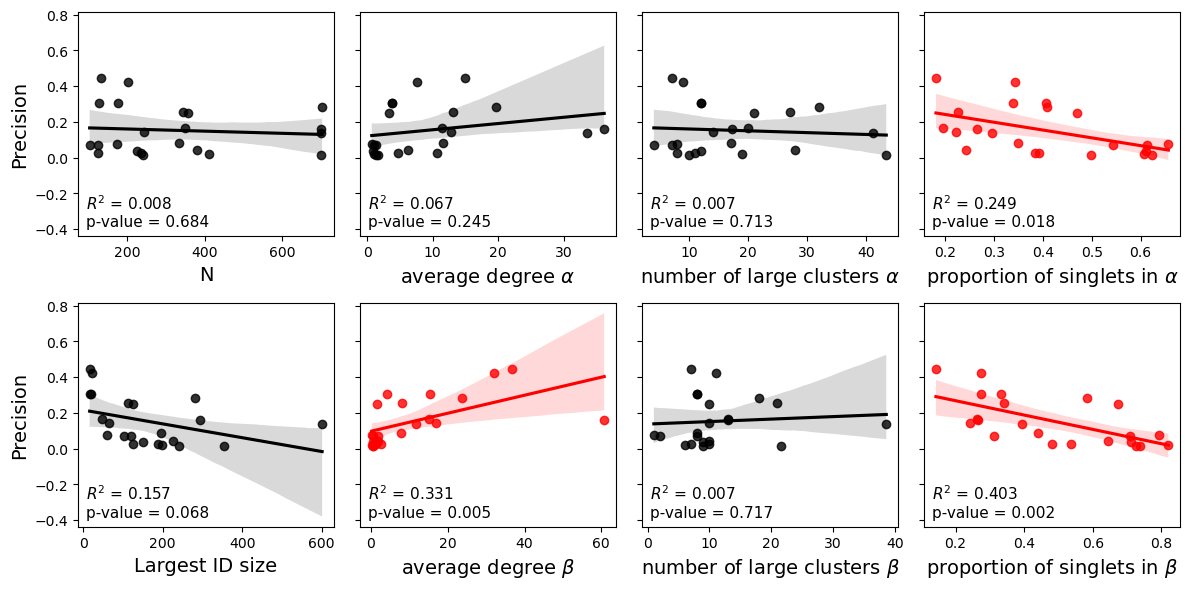

In [13]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12,6), sharey=True)
ax=axs.ravel(order='F')
titles = {'N':'N',
          'largest_id':'Largest ID size',
          'avg_degree_A':r'average degree $\alpha$',
          'avg_degree_B':r'average degree $\beta$',
          'large_clus_A':r'number of large clusters $\alpha$',
          'large_clus_B':r'number of large clusters $\beta$',
          'prop_singlets_A':r'proportion of singlets in $\alpha$',
          'prop_singlets_B':r'proportion of singlets in $\beta$',}

for w,c in enumerate(titles.keys()):
    assert all_res.shape[0] == len(epitopes)
    p,R,R_adj = simple_regplot(all_res,[c],'prop_correct')
    
    # ax[w].set_title(r'$R^2$ = ' + str(R.round(3)) + ', p-value = ' + str(p.round(3)), loc='left')
    ax[w].text(0.03,0.03,r'$R^2$ = ' + str(R.round(3)) + '\np-value = ' + str(p.round(3)), 
                        transform=ax[w].transAxes, verticalalignment='bottom', horizontalalignment='left',
                        fontdict={'size':11})

    col1= 'k'
    col2= 'k'
    if p < 0.05:
        col1='red'
    sns.regplot(data=all_res, x = c, y = 'prop_correct', ax=ax[w], color=col1, x_ci='ci', ci=95)

    if (w == 0) | (w == 1):
        ax[w].set_ylabel('Precision', fontsize=14)
    else:
        ax[w].set_ylabel('')
    ax[w].set_xlabel(titles[c], fontsize=14)

plt.tight_layout()
plt.savefig(save_folder1 + 'GA_correlations_with_TPR.png',
                bbox_inches="tight")
plt.show()

In [14]:
for x in titles.keys():
    all_res[x+'_norm'] = (all_res[x]-all_res[x].mean())/all_res[x].mean()

In [15]:
p,R,R_adj = simple_regplot(all_res,[x+'_norm' for x in titles.keys()],'prop_correct')

['N_norm', 'largest_id_norm', 'avg_degree_A_norm', 'avg_degree_B_norm', 'large_clus_A_norm', 'large_clus_B_norm', 'prop_singlets_A_norm', 'prop_singlets_B_norm'] prop_correct
prop_correct ~ N_norm + largest_id_norm + avg_degree_A_norm + avg_degree_B_norm + large_clus_A_norm + large_clus_B_norm + prop_singlets_A_norm + prop_singlets_B_norm
                            OLS Regression Results                            
Dep. Variable:           prop_correct   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     6.456
Date:                Tue, 21 May 2024   Prob (F-statistic):            0.00169
Time:                        00:25:52   Log-Likelihood:                 31.050
No. Observations:                  22   AIC:                            -44.10
Df Residuals:                      13   BIC:                            -34.28
Df Model:                  

In [16]:
x = ['N','largest_id','avg_degree_A','avg_degree_B','prop_singlets_A','prop_singlets_B']
p,R,R_adj = simple_regplot(all_res,[x+'_norm' for x in x],'prop_correct')

['N_norm', 'largest_id_norm', 'avg_degree_A_norm', 'avg_degree_B_norm', 'prop_singlets_A_norm', 'prop_singlets_B_norm'] prop_correct
prop_correct ~ N_norm + largest_id_norm + avg_degree_A_norm + avg_degree_B_norm + prop_singlets_A_norm + prop_singlets_B_norm
                            OLS Regression Results                            
Dep. Variable:           prop_correct   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     3.175
Date:                Tue, 21 May 2024   Prob (F-statistic):             0.0324
Time:                        00:25:52   Log-Likelihood:                 22.424
No. Observations:                  22   AIC:                            -30.85
Df Residuals:                      15   BIC:                            -23.21
Df Model:                           6                                         
Covariance Type:            no